Accuracy: 0.8977


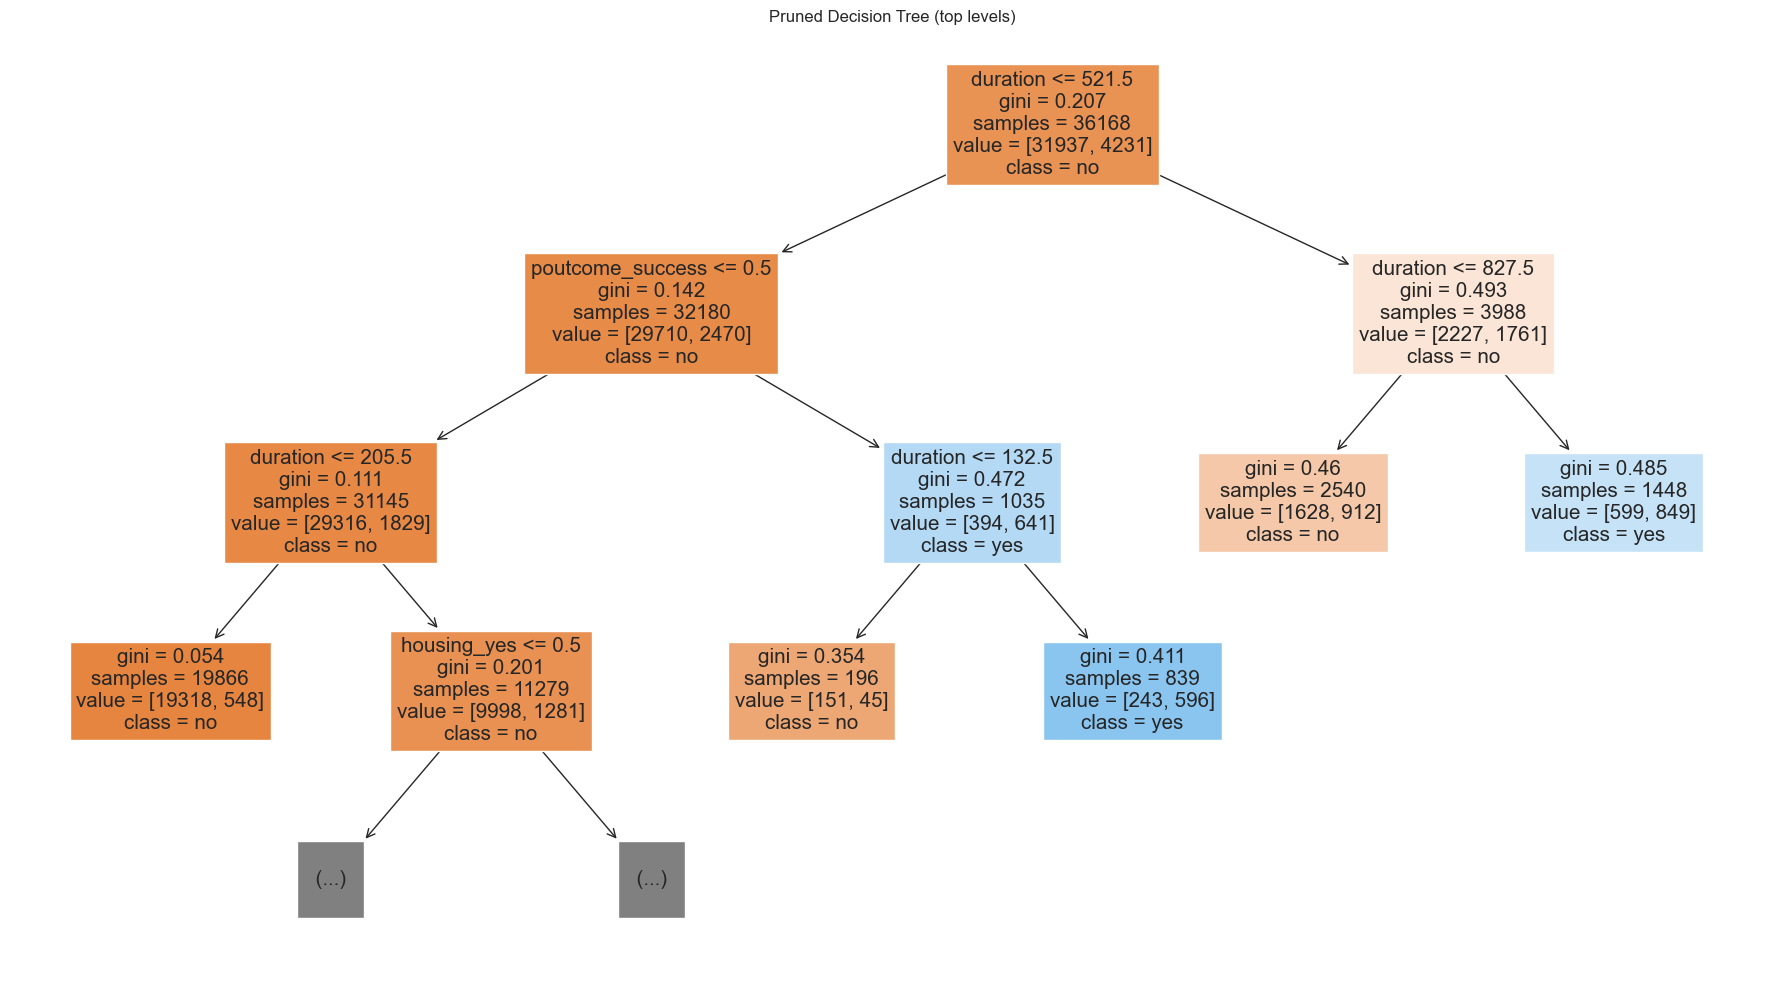

In [8]:


import io, zipfile, os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score

# ---- 1) Load dataset from the ZIP ----
zip_path = r"C:\Users\anime\Downloads\bank+marketing (1)\bank.zip"

with zipfile.ZipFile(zip_path) as zf:
    # Try common filenames from the UCI dataset
    candidates = [
        "bank-full.csv", "bank.csv",
        "bank-additional-full.csv", "bank-additional/bank-additional-full.csv"
    ]
    # Find the first candidate that exists in the zip
    members = {name.lower(): name for name in zf.namelist()}
    csv_name = None
    for c in candidates:
        if c.lower() in members:
            csv_name = members[c.lower()]
            break
    if csv_name is None:
        raise FileNotFoundError(f"No expected CSV found in zip. Found: {zf.namelist()}")

    with zf.open(csv_name) as f:
        # UCI files use ';' as delimiter
        df = pd.read_csv(io.TextIOWrapper(f, encoding="utf-8"), sep=';')

# ---- 2) Prepare features/target (handles both 'y' and 'deposit') ----
target_col = "deposit" if "deposit" in df.columns else "y"
y = df[target_col].astype(str).str.lower().map({"yes": 1, "no": 0})
if y.isna().any():
    # If target is already 0/1, just take it
    if set(df[target_col].unique()) <= {0, 1}:
        y = df[target_col].astype(int)
    else:
        raise ValueError(f"Unexpected target values in {target_col}: {df[target_col].unique()}")

X = df.drop(columns=[target_col])

# One-hot encode categoricals; keep numeric columns as-is
X = pd.get_dummies(X, drop_first=True)

# ---- 3) Train/test split ----
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ---- 4) Train a pruned Decision Tree ----
# Start with a mild pruning to avoid overfitting; adjust ccp_alpha if needed
clf = DecisionTreeClassifier(random_state=42, ccp_alpha=0.002)
clf.fit(X_train, y_train)

# ---- 5) Evaluate ----
y_pred = clf.predict(X_test)
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))

# ---- 6) Visualize ----
plt.figure(figsize=(18, 10))
plot_tree(
    clf,
    feature_names=X.columns,
    class_names=["no", "yes"],
    filled=True,
    max_depth=3  # show top levels for readability; remove to show full tree
)
plt.title("Pruned Decision Tree (top levels)")
plt.tight_layout()
plt.show()
